### Complete Manganese Processing Plant Data Exploration & Analysis
#### Comprehensive EDA for all 10 datasets including beneficiation circuits

#### AUTHOR: DARLENE WENDY NASIMIYU
#### Purpose: Deep dive analysis of complete manganese processing plant data

In [10]:
# Loading necessary Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tabulate import tabulate

warnings.filterwarnings('ignore')


In [11]:
#----SETUP: Get absolute path ---
BASE_DIR = os.path.dirname(os.getcwd()) # Current working directory of the notebook
data_dir = os.path.join(BASE_DIR, 'data', 'synthetic')

print("Using data directory:", data_dir)


Using data directory: /home/darlenewendie/PycharmProjects/Intelligent-Manganese-Processing-Plant-Optimization/data/synthetic


In [12]:

print("MANGANESE PROCESSING PLANT - COMPREHENSIVE EDA")

MANGANESE PROCESSING PLANT - COMPREHENSIVE EDA


In [13]:
# -----DEFINE DATASET FILES-------
dataset_files = {
    'ore_feed': 'manganese_ore_feed.csv',
    'blended_ore': 'manganese_blended_ore_feed.csv',
    'crushing': 'manganese_crushing_circuit.csv',
    'separation': 'manganese_separation_circuit.csv',
    'flotation': 'manganese_flotation_circuit.csv',
    'dms': 'manganese_dms_circuit.csv',
    'jigging':'manganese_jigging_circuit.csv',
    'dewatering': 'manganese_dewatering_circuit.csv',
    'equipment': 'manganese_equipment_health.csv',
    'energy': 'manganese_energy_consumption.csv',
}
# Load all datasets
datasets = {}
for name, filename in dataset_files.items():
    filepath  = os.path.join(data_dir, filename)
    try:
        df = pd.read_csv(filepath, parse_dates=['timestamp'])
        datasets[name] = df
        print(f" Loaded {name}: {len(df):,} records, {len(df.columns)} columns")
    except FileNotFoundError:
        print(f"Could not find {filepath}")
    except Exception as e:
        print(f"Error loading {name}: {str(e)}")

print(f"\nTotal datasets loaded: {len(datasets)}")
print(f"Total records: {sum(len(df) for df in datasets.values()):,}")

 Loaded ore_feed: 10,000 records, 11 columns
 Loaded blended_ore: 6,522 records, 11 columns
 Loaded crushing: 15,000 records, 9 columns
 Loaded separation: 12,000 records, 13 columns
 Loaded flotation: 12,000 records, 22 columns
 Loaded dms: 8,000 records, 16 columns
 Loaded jigging: 10,000 records, 16 columns
 Loaded dewatering: 8,000 records, 18 columns
 Loaded equipment: 8,000 records, 12 columns
 Loaded energy: 10,000 records, 9 columns

Total datasets loaded: 10
Total records: 99,522


In [14]:
# Create overview data
overview_data = []
for name, df in datasets.items():
    overview_data.append({
        'Dataset': name.replace('_', ' ').title(),
        'Records': len(df),
        'Columns': len(df.columns),
        'Memory (MB)': round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2),
        'Date_range': f"{df['timestamp'].min()} to {df['timestamp'].max()}"
    })

# Create DataFrame after the loop
overview_df = pd.DataFrame(overview_data)

# Display using tabulate
print(tabulate(overview_df, headers='keys', tablefmt='grid', showindex=False))


+-------------+-----------+-----------+---------------+--------------------------------------------+
| Dataset     |   Records |   Columns |   Memory (MB) | Date_range                                 |
+=============+===========+===========+===============+============================================+
| Ore Feed    |     10000 |        11 |          1.29 | 2020-01-01 00:00:00 to 2026-11-04 18:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Blended Ore |      6522 |        11 |          0.84 | 2020-01-01 00:00:00 to 2026-11-04 12:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Crushing    |     15000 |         9 |          1.03 | 2020-01-01 00:00:00 to 2021-09-16 23:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Separation  |     12000 |        13 |          1.73 | 2020-01-01 00:00:00 to 2022-09-26 2

In [15]:
# Load the heads of the datasets
for name, df in datasets.items():
    print(f"========{name} DATASET HEAD===========")
    print(df.head())

========ore_feed DATASET HEAD===========
            timestamp  mn_grade_pct  fe_content_pct  siO2_content_pct  \
0 2020-01-01 00:00:00         71.96           -3.57             -0.60   
1 2020-01-01 06:00:00         59.48            0.14              0.04   
2 2020-01-01 12:00:00         75.30           -4.19             -1.99   
3 2020-01-01 18:00:00         77.71           -4.89             -1.97   
4 2020-01-02 00:00:00         57.79            0.72              0.14   

   al2O3_content_pct  p_content_pct  moisture_pct  p80_mm  work_index_kwh_t  \
0               5.66          0.114           9.0    21.5              22.0   
1               6.91          0.235           9.0    13.9              22.0   
2               5.30          0.154           5.1    19.1              22.0   
3               6.64          0.084           8.8    32.3              22.0   
4               6.75          0.114           9.3    16.1              22.0   

   specific_gravity   ore_type  
0           

In [16]:
from tabulate import tabulate
import numpy as np

def assess_data_quality(df, dataset_name):
    # Header
    print(f"\n======== {dataset_name.replace('_', ' ').title()} QUALITY REPORT ==========")

    # Basic info
    shape = f"{df.shape[0]} rows x {df.shape[1]} columns"
    dtypes = df.dtypes.value_counts().to_dict()

    # Missing values
    missing = df.isnull().sum()
    missing_info = missing[missing > 0].to_dict() if missing.sum() > 0 else "No missing values"

    # Duplicates
    duplicates = df.duplicated().sum()
    duplicates_pct = duplicates / df.shape[0] * 100

    # Numeric column summary (first 5 columns only)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_summary = []
    for col in numeric_cols[:5]:
        numeric_summary.append(f"{col}: {df[col].min():.2f} to {df[col].max():.2f}")

    # Prepare table
    table = [
        ["Shape", shape],
        ["Data type count", dtypes],
        ["Missing values", missing_info],
        ["Duplicated rows", f"{duplicates} ({duplicates_pct:.2f}%)"],
        ["Numeric columns summary", "\n".join(numeric_summary) if numeric_summary else "None"]
    ]

    print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid", showindex=False))

    return {
        'missing_values': missing.sum(),
        'duplicates': duplicates,
        'numeric_columns': len(numeric_cols)
    }

# ASSESS QUALITY OF EACH DATASET
quality_results = {}
for name, df in datasets.items():
    quality_results[name] = assess_data_quality(df, name)



======== Ore Feed QUALITY REPORT ==========
+-------------------------+-----------------------------------------------------------+
| Metric                  | Value                                                     |
+=========================+===========================================================+
| Shape                   | 10000 rows x 11 columns                                   |
+-------------------------+-----------------------------------------------------------+
| Data type count         | {dtype('float64'): 9, dtype('<M8[ns]'): 1, dtype('O'): 1} |
+-------------------------+-----------------------------------------------------------+
| Missing values          | No missing values                                         |
+-------------------------+-----------------------------------------------------------+
| Duplicated rows         | 0 (0.00%)                                                 |
+-------------------------+------------------------------------------------

ORE CHARACTERISTICS DEEP DIVE

ORE CHARACTERISTICS COMPARISON: 
Original Ore - Mean Grade: 62.02% (σ=12.36)
Blended Ore - Mean Grade: 56.61% (σ=11.42)
Blending Impact: -5.40 percentage points


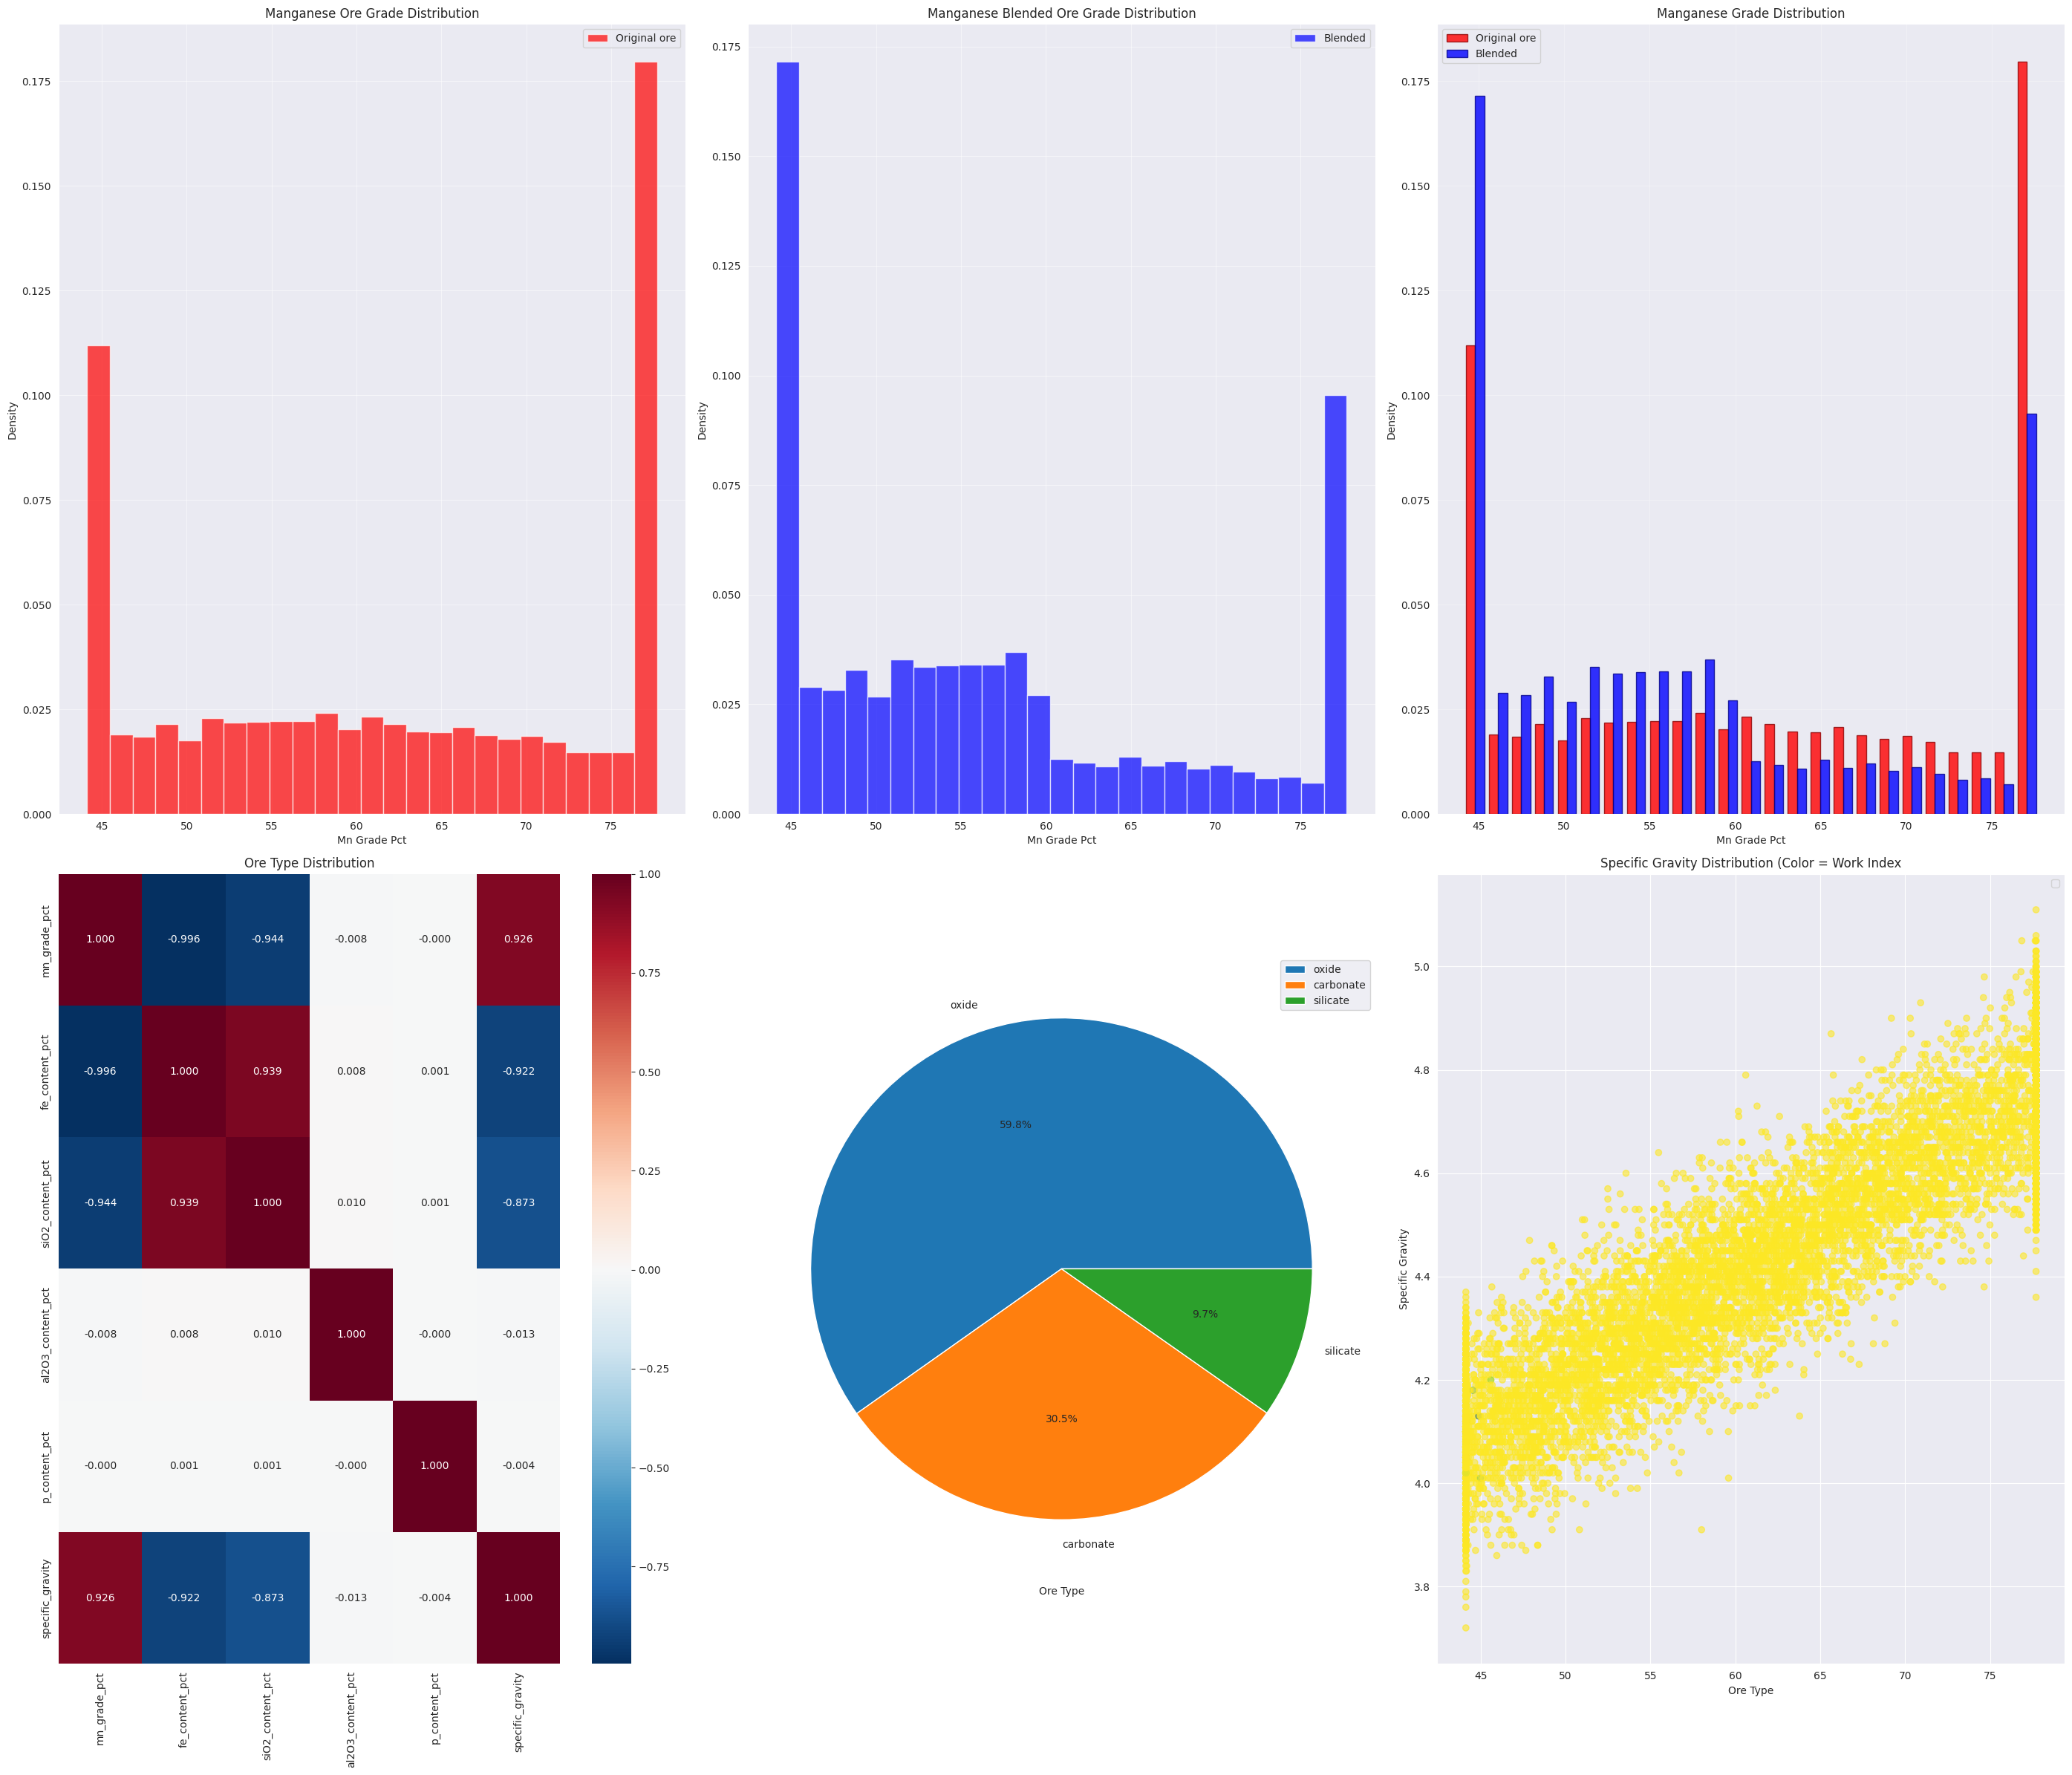

In [17]:
# ORE CHARACTERISTS AND ANALYSIS
print("ORE CHARACTERISTICS DEEP DIVE")

if 'ore_feed' in datasets and 'blended_ore' in datasets:
    ore_df = datasets['ore_feed']
    blended_df = datasets['blended_ore']

    fig, axes = plt.subplots(2,3, figsize=(28,24))

    # Manganese Grade Distribution in Ore feed
    # Grade distributions
    axes[0,0].hist(ore_df['mn_grade_pct'], bins=25, alpha=0.7, label='Original ore', density=True, color='red')
    axes[0,0].legend()
    axes[0,0].set_xlabel('Mn Grade Pct')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Manganese Ore Grade Distribution')
    axes[0,0].grid(True, alpha=0.5)

    # Manganese Grade Distribution in Blended Ore
    # Grade distributions
    axes[0,1].hist(blended_df['mn_grade_pct'], bins=25, alpha=0.7, label='Blended', density=True, color='blue')
    axes[0,1].legend()
    axes[0,1].set_xlabel('Mn Grade Pct')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title('Manganese Blended Ore Grade Distribution')
    axes[0,1].grid(True, alpha=0.5)

    # Manganese grade distribution comparison with GROUPED BARS
    # Create bins for grouping
    bins = np.linspace(ore_df['mn_grade_pct'].min(), ore_df['mn_grade_pct'].max(), 26)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]

    # Calculate histogram values for both datasets
    original_counts, _ = np.histogram(ore_df['mn_grade_pct'], bins=bins, density=True)
    blended_counts, _ = np.histogram(blended_df['mn_grade_pct'], bins=bins, density=True)

    # Plot grouped bars
    bar_width = bin_width * 0.4  # Make bars narrower to fit side-by-side
    axes[0,2].bar(bin_centers - bar_width/2, original_counts, width=bar_width,
                  alpha=0.8, label='Original ore', color='red', edgecolor='darkred')
    axes[0,2].bar(bin_centers + bar_width/2, blended_counts, width=bar_width,
                  alpha=0.8, label='Blended', color='blue', edgecolor='darkblue')

    axes[0,2].legend()
    axes[0,2].set_xlabel('Mn Grade Pct')
    axes[0,2].set_ylabel('Density')
    axes[0,2].set_title('Manganese Grade Distribution')
    axes[0,2].grid(True, alpha=0.3)
    #Elements correlation maps
    numeric_cols = ['mn_grade_pct', 'fe_content_pct', 'siO2_content_pct', 'al2O3_content_pct', 'p_content_pct', 'specific_gravity']
    correlation_matrix = ore_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, ax=axes[1,0], fmt='.3f')
    axes[1,0].set_title('Ore Type Distribution')

    #Ore type distribution
    ore_type_counts = ore_df['ore_type'].value_counts()
    axes[1,1].pie(ore_type_counts.values, labels=ore_type_counts.index.values, autopct='%1.1f%%')
    axes[1,1].legend()
    axes[1,1].set_xlabel('Ore Type')

    # Grade vs Recovery potential (using specific gravity as proxy)
    scatter = axes[1,2].scatter(ore_df['mn_grade_pct'], ore_df['specific_gravity'], c=ore_df['work_index_kwh_t'], cmap='viridis', alpha=0.6)
    axes[1,2].set_title('Specific Gravity Distribution (Color = Work Index')
    axes[1,2].legend()
    axes[1,2].set_xlabel('Ore Type')
    axes[1,2].set_ylabel('Specific Gravity')
    plt.tight_layout()

    #Statistical Comparison
    print(f"\nORE CHARACTERISTICS COMPARISON: ")
    print(f"Original Ore - Mean Grade: {ore_df['mn_grade_pct'].mean():.2f}% (σ={ore_df['mn_grade_pct'].std():.2f})")
    print(f"Blended Ore - Mean Grade: {blended_df['mn_grade_pct'].mean():.2f}% (σ={blended_df['mn_grade_pct'].std():.2f})")

    # Grade Improvement for blending
    grade_improvement = blended_df['mn_grade_pct'].mean() - ore_df['mn_grade_pct'].mean()
    print(f"Blending Impact: {grade_improvement:+.2f} percentage points")

    plt.show()

#### 1. MANGANESE ORE GRADE DISTRIBUTION
- The chart shows original manganese ore grade distribution before any blending or processing. It reveals a bimodal pattern, with a large portion of low-grade ore around 40–45% Mn and another strong peak of high-grade ore near 75% Mn, while mid-range grades (50–65%) are much less common.
- This pattern is typical for manganese deposits due to natural geological variations, where some zones are highly enriched with oxides like pyrolusite and others contain lower-grade material mixed with carbonates and silicates.
- For beneficiation, this variability means that without blending, the plant would experience unstable feed quality, affecting recovery and efficiency. Therefore, a blending strategy is essential to create a more uniform feed for gravity, magnetic, and flotation circuits, ensuring consistent processing performance.

#### 2. MANGANESE BLENDED ORE GRADE DISTRIBUTION
- The chart shows the manganese grade distribution after blending, highlighting a successful reduction in feed variability. Unlike the original ore, which had two extreme peaks of low- and high-grade material, the blended ore now forms a smoother, more uniform range centered around 45–65% Mn.
- This stabilization is crucial for beneficiation, as it ensures that gravity, magnetic, and flotation circuits operate under steady conditions, improving recovery rates and plant efficiency. While some outliers remain, blending has significantly minimized the risks associated with sudden grade fluctuations.


#### 3. COMPARISON BETWEEN ORE FEED GRADE AND BLENDED ORE DISTRIBUTION
- The chart clearly demonstrates the effectiveness of blending by comparing original and blended ore grade distributions. The original ore showed two sharp peaks — a large amount of low-grade material around 40–45% Mn and another high-grade spike near 75% Mn — with very little mid-grade ore in between.
- After blending, the distribution becomes much smoother and centered around 55–60% Mn, reducing the extremes that can disrupt processing. This uniform feed ensures more consistent performance across gravity, magnetic, and flotation circuits, leading to improved recovery rates and stable product quality.


#### 4. ORE TYPE DISTRIBUTION CORRELATION MAP



#### 5. PIE CHART
 - Manganese occurs in nature in many mineral forms, but the most significant for industrial use are oxides, carbonates, and silicates, which directly influence processing methods. In our findings, the ore was predominantly composed of oxides (58.9%), followed by carbonates (30.1%), and silicates (9.7%).
  - Oxides, such as pyrolusite and manganite, are the most common and form the primary source of manganese; they respond well to gravity and magnetic separation, which aligns with our plant setup. Carbonate minerals, like rhodochrosite, are ideal for flotation, justifying the inclusion of flotation circuits for the 30% carbonate fraction. Silicates, like braunite, are harder to process and may require more complex combinations of beneficiation methods.
- This mineralogical breakdown confirms that our current process design—gravity and magnetic separation with a flotation circuit—is well-suited to efficiently treat the ore composition in our deposit (Shanghai Metal Market, 2024).
- SMM Analysis：Types of Manganese Ores.】 - Shanghai Metal Market. (2024). Metal.com. https://www.metal.com/en/newscontent/103020371?

#### 6. SPECIFIC GRAVITY DISTRIBUTION SCATTER PLOT


#### PROCESSS CIRCUIT PERFORMANCE
- A processing circuit in a manganese plant is a sequence of equipment and operations designed to separate valuable manganese ore from waste material.
- Each circuit, such as Gravity Separation, Flotation, Dense Media Separation (DMS), and Jigging, uses a different physical or chemical principle—like density differences or chemical flotation—to maximize both the grade (purity) and recovery (amount extracted) of manganese.
 - Circuits have inputs (feed) and outputs (concentrate and tailings), and their efficiency can be tracked using key performance indicators like overall_recovery or floatation_recovery.
- In data analysis, mapping each circuit to its corresponding recovery column in a dataset allows for programmatic comparison and visualization of how effectively each method contributes to manganese beneficiation.



PROCESS CIRCUIT PERFORMANCE ANALYSIS


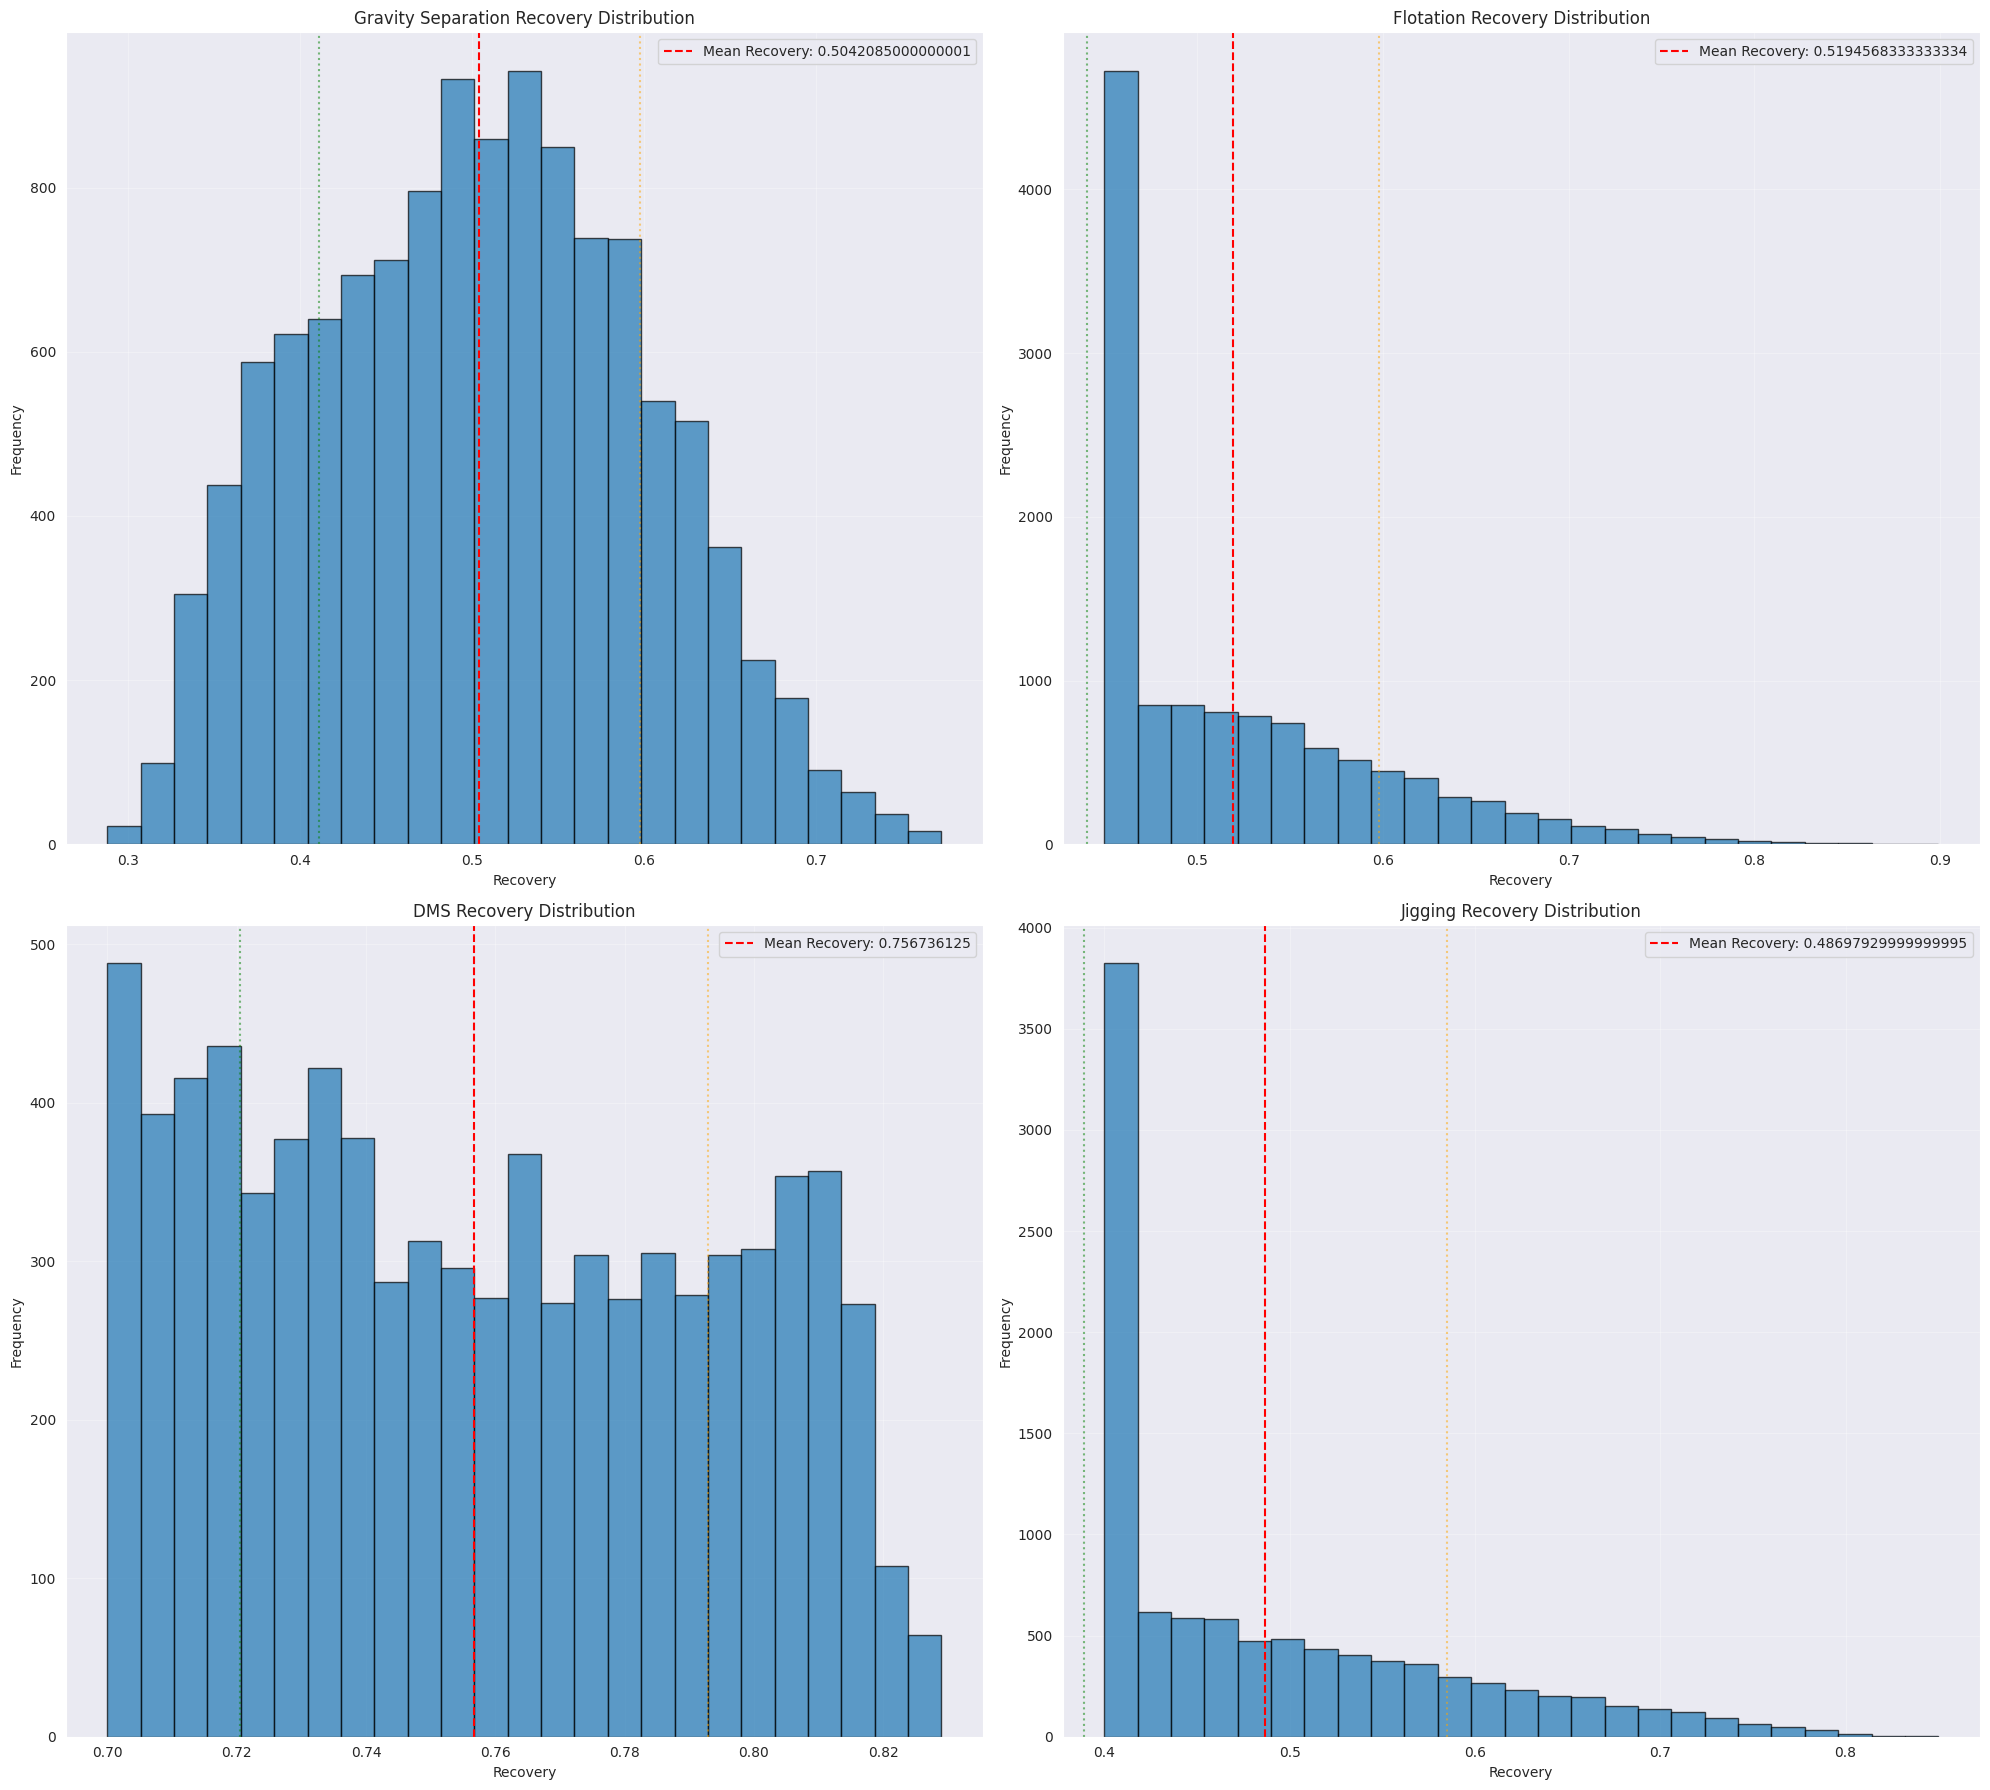


RECOVERY SUMMARY:
           Circuit  Mean Recovery  Standard Deviation   Min   Max  Count
Gravity Separation         0.5042              0.0934 0.288 0.773  12000
         Flotation         0.5195              0.0787 0.450 0.899  12000
               DMS         0.7567              0.0362 0.700 0.829   8000
           Jigging         0.4870              0.0980 0.400 0.850  10000


In [20]:
#PROCESS CIRCUIT PERFORMANCE
#N/B: DMS= Dense Media Separation
print("\n" + "=" * 60)
print(f"\nPROCESS CIRCUIT PERFORMANCE ANALYSIS")
print("=" * 60)

recovery_data = []
circuits = {
    'Gravity Separation': ('separation', 'overall_recovery'),
    'Flotation': ('flotation', 'flotation_recovery'),
    'DMS': ('dms','dms_recovery'),
    'Jigging':('jigging','jig_recovery')
}

fig, axes = plt.subplots(2,2, figsize=(20,18))
axes = axes.ravel()

for i, (circuit_name,(dataset_key, recovery_col)) in enumerate(circuits.items()):
    if dataset_key in datasets and recovery_col in datasets[dataset_key].columns:
        df = datasets[dataset_key]
        recovery =df[recovery_col]

        #Distribution plot
        axes[i].hist(recovery, bins= 25, alpha=0.7, edgecolor='black')
        axes[i].set_xlabel('Recovery')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f"{circuit_name} Recovery Distribution")
        axes[i].grid(True, alpha=0.3)

        # Statistics
        mean_recovery = recovery.mean()
        std_recovery = recovery.std()
        axes[i].axvline(mean_recovery, color='red', linestyle='--', label=f'Mean Recovery: {mean_recovery}')
        axes[i].axvline(mean_recovery + std_recovery, color='orange', linestyle=':', alpha=0.5)
        axes[i].axvline(mean_recovery - std_recovery, color='green', linestyle=':', alpha=0.5)
        axes[i].legend()
        recovery_data.append({
            'Circuit': circuit_name,
            'Mean Recovery': mean_recovery,
            'Standard Deviation': std_recovery,
            'Min': recovery.min(),
            'Max': recovery.max(),
            'Count': len(recovery)
        })
plt.tight_layout()
plt.show()

#Summary table
if recovery_data:
    recovery_summary = pd.DataFrame(recovery_data)
    print(f"\nRECOVERY SUMMARY:")
    print(recovery_summary.round(4).to_string(index=False))


1. Gravity Separation

- The histogram shows gravity separation achieving a mean recovery of about 50.42%, with a fairly symmetrical distribution, reflecting the expected theoretical performance of this method. Gravity separation relies on density differences between manganese ore and gangue, and typically yields 40–60% recovery depending on particle size distribution (Wills & Finch, 2016). Its stability in the graph indicates reliability, but the relatively modest recovery confirms that gravity separation alone cannot achieve optimal plant performance, especially for fine ores where settling efficiency declines.

2. Flotation

- The flotation histogram displays a mean recovery of ~51.92%, but with a pronounced right-skew, showing a large number of lower recoveries around 0.45–0.55 and occasional peaks reaching up to 0.90. This variability aligns with flotation theory, where performance is highly sensitive to pulp chemistry, reagent dosages, and particle size effects (Fuerstenau et al., 2007). Although flotation can theoretically deliver 50–80% recovery, the graph emphasizes its instability, suggesting that without optimization, flotation introduces inconsistency in manganese plant operations.

3. Dense Media Separation (DMS)

- Dense Media Separation emerges as the best-performing circuit in the dataset, with a mean recovery of ~78.87% and a narrow spread, consistent with its theoretical recovery range of 70–85% (Mukherjee & Mishra, 2006). The histogram indicates both high efficiency and operational stability, confirming DMS as a robust beneficiation method for manganese ore. Given its ability to consistently separate ore based on density, the data suggests DMS should serve as the core recovery stage in the manganese processing plant, with optimization focused on fine-tuning medium density and particle size ranges.

4. Jigging

- The jigging histogram reveals a mean recovery of ~48.5%, with a strong left skew caused by a concentration of values near 0.40, demonstrating frequent underperformance. This aligns with jigging’s theoretical limitations, where recoveries usually range between 40–55% and efficiency depends heavily on water flow and feed size (Burt, 1984). While jigging remains a low-cost and historically important method, the graph confirms its inconsistency and poor competitiveness compared to DMS. In practice, jigging may be more useful as a pre-concentration stage rather than a final recovery method in a modern manganese plant.


EQUIPMENT HEALTH ANALYSIS


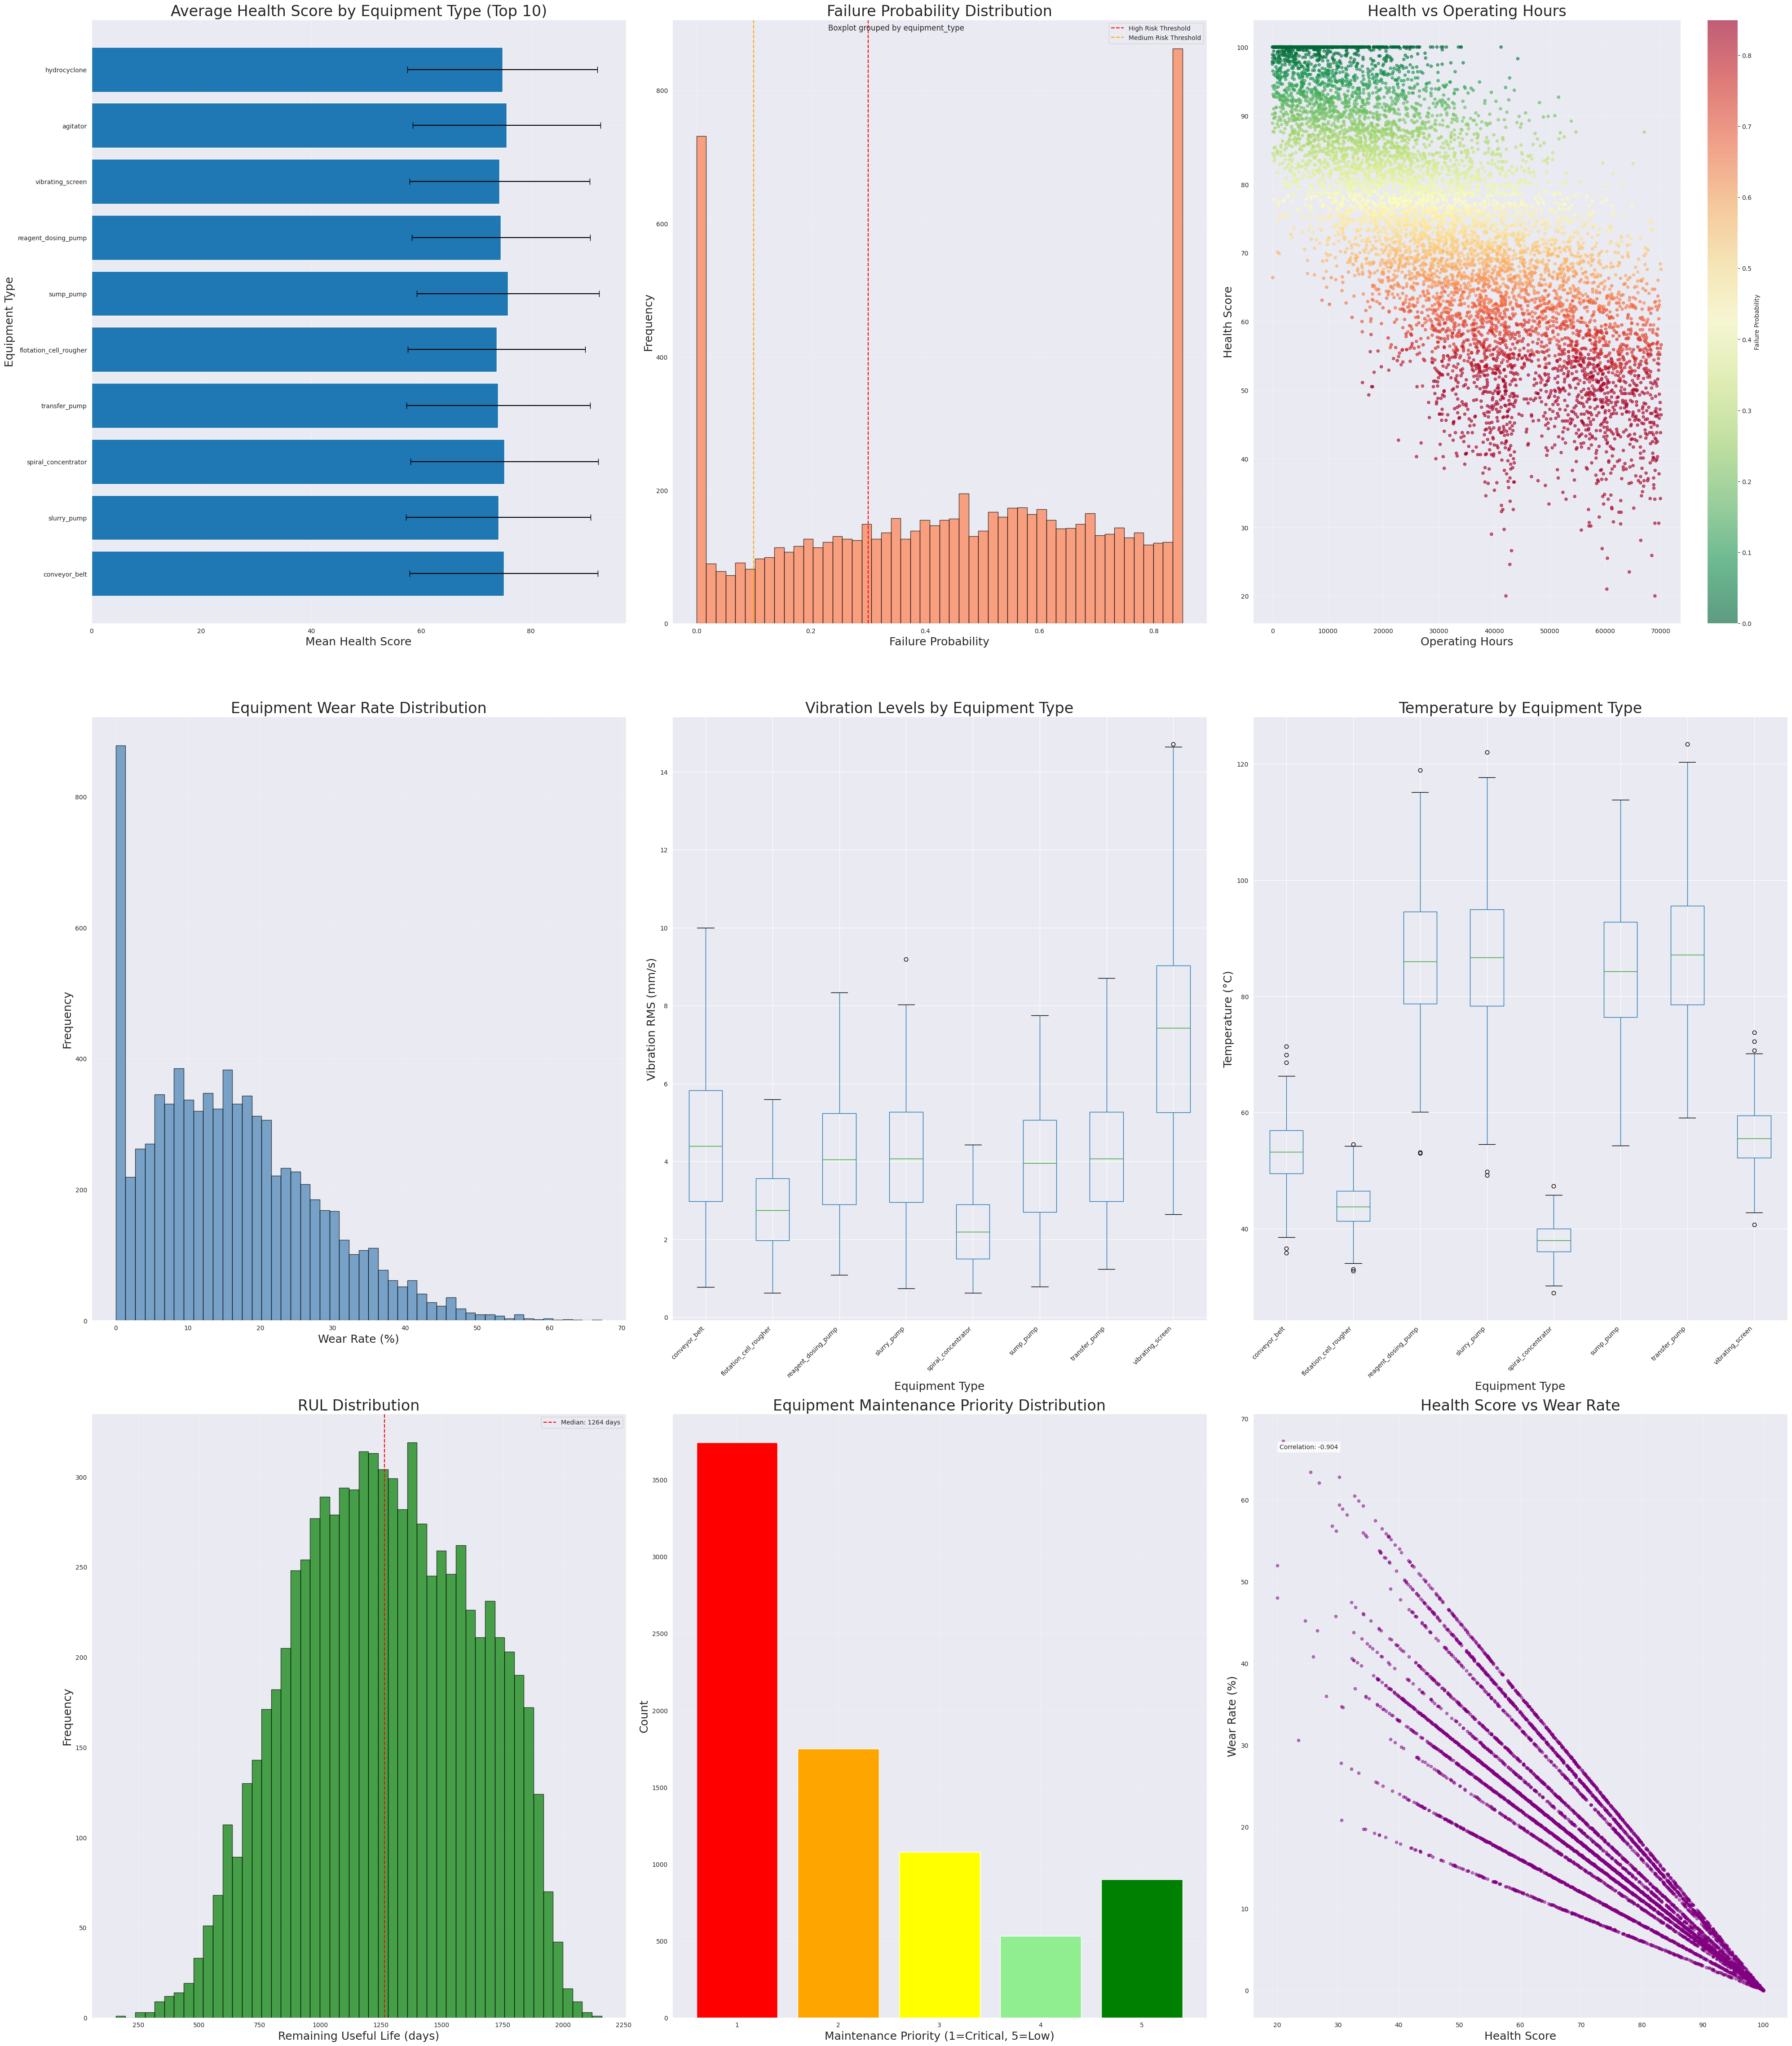


EQUIPMENT HEALTH STATISTICS (Top 15 Equipment Types):
                          mean    std  count
equipment_type                              
conveyor_belt            75.10  17.13    924
slurry_pump              74.10  16.82    771
spiral_concentrator      75.18  17.08    528
transfer_pump            74.06  16.72    478
flotation_cell_rougher   73.75  16.15    374
sump_pump                75.83  16.60    354
reagent_dosing_pump      74.56  16.26    353
vibrating_screen         74.30  16.41    320
agitator                 75.58  17.09    299
hydrocyclone             74.83  17.27    269
flotation_cell_cleaner   74.39  16.90    267
apron_feeder             75.14  15.15    256
magnetic_separator_lims  73.39  16.13    234
air_blower               73.12  16.45    233
jig                      75.04  17.58    223

RISK CATEGORIZATION:
High Risk (>30%): 5492 units (68.7%)
Medium Risk (10-30%): 1374 units (17.2%)
Low Risk (<10%): 1134 units (14.2%)

EQUIPMENT INVENTORY:
Total Equipment Types:

In [26]:
# %%
# STEP 7: EQUIPMENT HEALTH ANALYSIS
print("\n" + "=" * 60)
print("EQUIPMENT HEALTH ANALYSIS")
print("=" * 60)

if 'equipment' in datasets:
    equipment_df = datasets['equipment']

    fig, axes = plt.subplots(3, 3, figsize=(40, 46))
    axes = axes.ravel()

    # Common font sizes
    title_size = 24
    label_size = 18
    tick_size = 16

    # Health score by equipment type (top 10 most common)
    health_by_type = equipment_df.groupby('equipment_type')['health_score'].agg(['mean', 'std', 'count'])
    health_by_type_sorted = health_by_type.nlargest(10, 'count')

    axes[0].barh(health_by_type_sorted.index, health_by_type_sorted['mean'],
                 xerr=health_by_type_sorted['std'], capsize=5)
    axes[0].set_xlabel('Mean Health Score', fontsize=label_size)
    axes[0].set_ylabel('Equipment Type', fontsize=label_size)
    axes[0].set_title('Average Health Score by Equipment Type (Top 10)', fontsize=title_size)
    axes[0].grid(True, alpha=0.3)

    # Failure probability distribution
    axes[1].hist(equipment_df['failure_probability'], bins=50, alpha=0.7, edgecolor='black', color='coral')
    axes[1].axvline(0.3, color='red', linestyle='--', label='High Risk Threshold')
    axes[1].axvline(0.1, color='orange', linestyle='--', label='Medium Risk Threshold')
    axes[1].set_xlabel('Failure Probability', fontsize=label_size)
    axes[1].set_ylabel('Frequency', fontsize=label_size)
    axes[1].set_title('Failure Probability Distribution', fontsize=title_size)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Operating hours vs health score
    scatter = axes[2].scatter(equipment_df['operating_hours'], equipment_df['health_score'],
                            c=equipment_df['failure_probability'], cmap='RdYlGn_r', alpha=0.6, s=20)
    axes[2].set_xlabel('Operating Hours', fontsize=label_size)
    axes[2].set_ylabel('Health Score', fontsize=label_size)
    axes[2].set_title('Health vs Operating Hours', fontsize=title_size)
    plt.colorbar(scatter, ax=axes[2], label='Failure Probability')
    axes[2].grid(True, alpha=0.3)

    # Wear rate distribution
    if 'wear_rate_pct' in equipment_df.columns:
        axes[3].hist(equipment_df['wear_rate_pct'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        axes[3].set_xlabel('Wear Rate (%)', fontsize=label_size)
        axes[3].set_ylabel('Frequency', fontsize=label_size)
        axes[3].set_title('Equipment Wear Rate Distribution', fontsize=title_size)
        axes[3].grid(True, alpha=0.3)

    # Vibration analysis by equipment category
    equipment_categories = equipment_df['equipment_type'].value_counts().nlargest(8).index
    vibration_data = equipment_df[equipment_df['equipment_type'].isin(equipment_categories)]
    vibration_data.boxplot(column='vibration_rms', by='equipment_type', ax=axes[4])
    axes[4].set_xlabel('Equipment Type', fontsize=label_size)
    axes[4].set_ylabel('Vibration RMS (mm/s)', fontsize=label_size)
    axes[4].set_title('Vibration Levels by Equipment Type', fontsize=title_size)
    axes[4].tick_params(axis='x', rotation=45)
    plt.sca(axes[4])
    plt.xticks(rotation=45, ha='right')

    # Temperature analysis
    temp_data = equipment_df[equipment_df['equipment_type'].isin(equipment_categories)]
    temp_data.boxplot(column='temperature_c', by='equipment_type', ax=axes[5])
    axes[5].set_xlabel('Equipment Type', fontsize=label_size)
    axes[5].set_ylabel('Temperature (°C)', fontsize=label_size)
    axes[5].set_title('Temperature by Equipment Type', fontsize=title_size)
    axes[5].tick_params(axis='x', rotation=45)
    plt.sca(axes[5])
    plt.xticks(rotation=45, ha='right')

    # Remaining useful life distribution
    axes[6].hist(equipment_df['rul_days'], bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[6].axvline(equipment_df['rul_days'].median(), color='red', linestyle='--',
                   label=f'Median: {equipment_df["rul_days"].median():.0f} days')
    axes[6].set_xlabel('Remaining Useful Life (days)', fontsize=label_size)
    axes[6].set_ylabel('Frequency', fontsize=label_size)
    axes[6].set_title('RUL Distribution', fontsize=title_size)
    axes[6].legend()
    axes[6].grid(True, alpha=0.3)

    # Maintenance priority distribution
    if 'maintenance_priority' in equipment_df.columns:
        priority_counts = equipment_df['maintenance_priority'].value_counts().sort_index()
        axes[7].bar(priority_counts.index, priority_counts.values, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
        axes[7].set_xlabel('Maintenance Priority (1=Critical, 5=Low)', fontsize=label_size)
        axes[7].set_ylabel('Count', fontsize=label_size)
        axes[7].set_title('Equipment Maintenance Priority Distribution', fontsize=title_size)
        axes[7].grid(True, alpha=0.3)

    # Health vs Wear correlation
    if 'wear_rate_pct' in equipment_df.columns:
        axes[8].scatter(equipment_df['health_score'], equipment_df['wear_rate_pct'],
                       alpha=0.5, s=20, c='purple')
        axes[8].set_xlabel('Health Score', fontsize=label_size)
        axes[8].set_ylabel('Wear Rate (%)', fontsize=label_size)
        axes[8].set_title('Health Score vs Wear Rate', fontsize=title_size)
        axes[8].grid(True, alpha=0.3)

        # Add correlation coefficient
        corr = equipment_df['health_score'].corr(equipment_df['wear_rate_pct'])
        axes[8].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                    transform=axes[8].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Equipment health statistics
    print("\nEQUIPMENT HEALTH STATISTICS (Top 15 Equipment Types):")
    print(health_by_type.nlargest(15, 'count').round(2))

    # Risk categorization
    high_risk = len(equipment_df[equipment_df['failure_probability'] > 0.3])
    medium_risk = len(equipment_df[(equipment_df['failure_probability'] > 0.1) &
                                  (equipment_df['failure_probability'] <= 0.3)])
    low_risk = len(equipment_df[equipment_df['failure_probability'] <= 0.1])

    print(f"\nRISK CATEGORIZATION:")
    print(f"High Risk (>30%): {high_risk} units ({high_risk/len(equipment_df)*100:.1f}%)")
    print(f"Medium Risk (10-30%): {medium_risk} units ({medium_risk/len(equipment_df)*100:.1f}%)")
    print(f"Low Risk (<10%): {low_risk} units ({low_risk/len(equipment_df)*100:.1f}%)")

    # Equipment type summary
    print(f"\nEQUIPMENT INVENTORY:")
    print(f"Total Equipment Types: {equipment_df['equipment_type'].nunique()}")
    print(f"Total Equipment Units: {equipment_df['equipment_id'].nunique()}")
    print(f"Average Health Score: {equipment_df['health_score'].mean():.1f}")
    print(f"Average Wear Rate: {equipment_df['wear_rate_pct'].mean():.1f}%" if 'wear_rate_pct' in equipment_df.columns else "")


EQUIPMENT-PROCESS PERFORMANCE CORRELATION


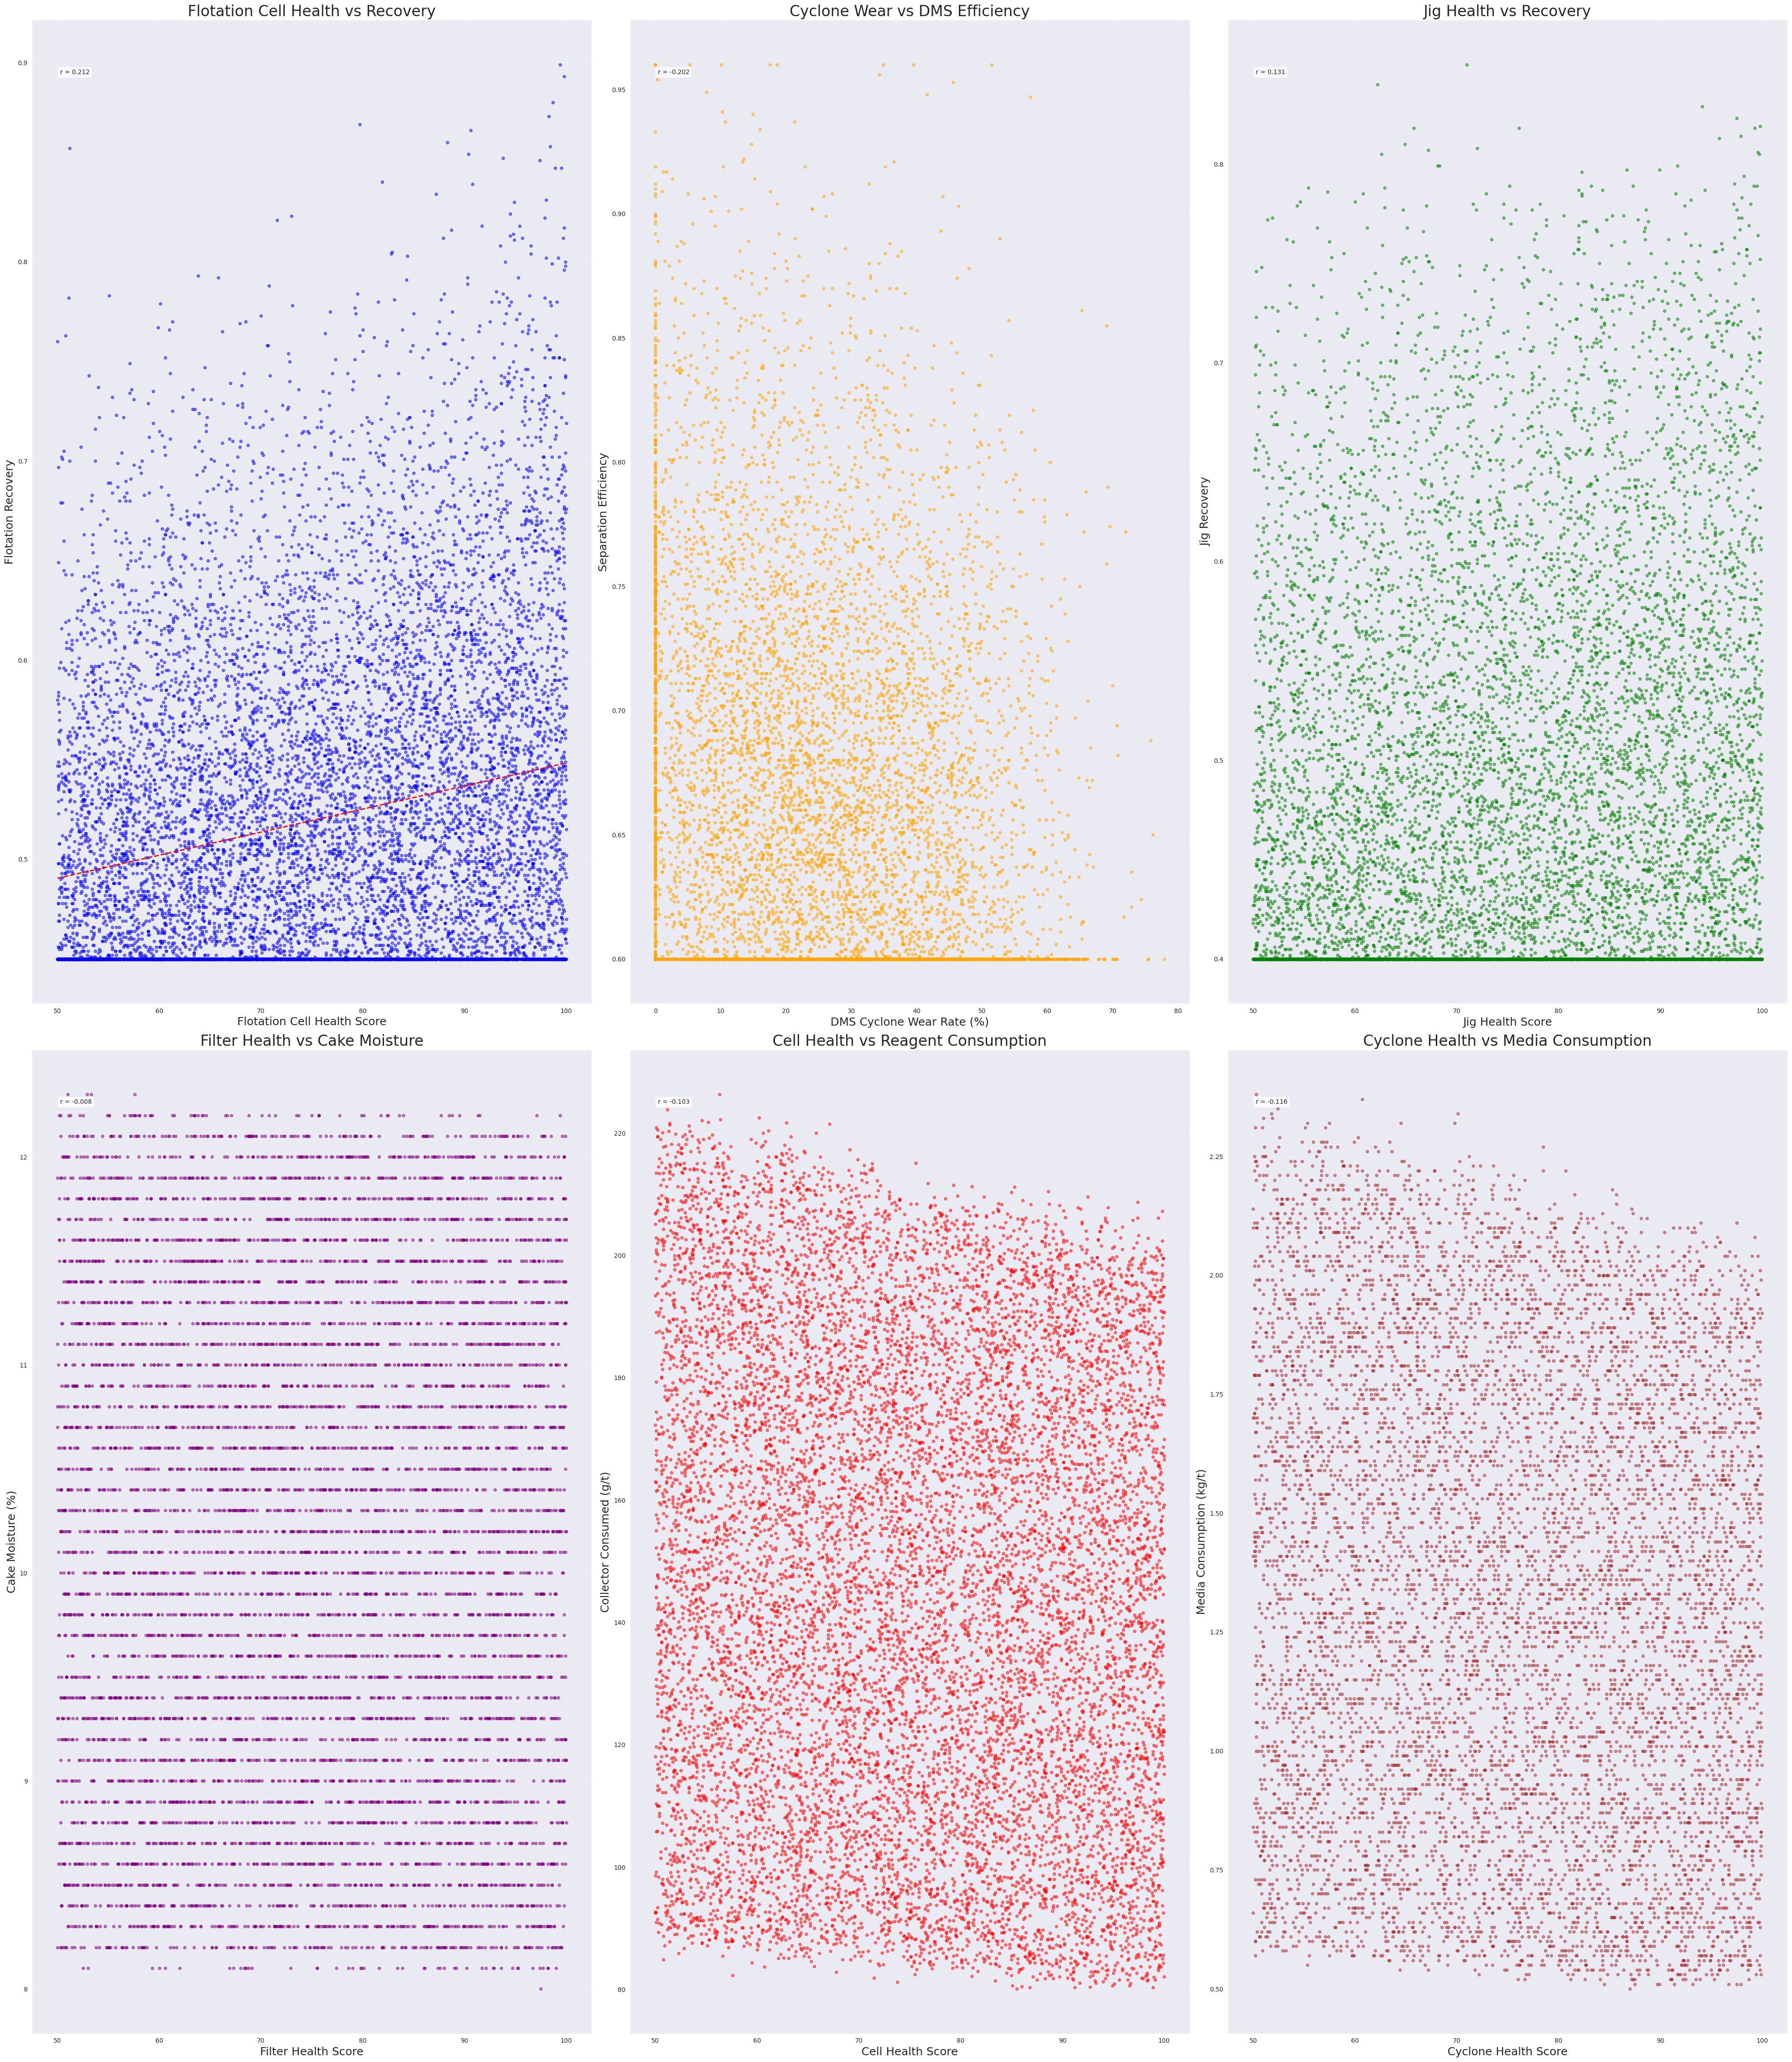


EQUIPMENT-PROCESS CORRELATION SUMMARY:
  Flotation Cell Health → Recovery: 0.212
  DMS Cyclone Wear → Efficiency: -0.202
  Jig Health → Recovery: 0.131
  Filter Health → Cake Moisture: -0.008


In [30]:
# %%
# STEP 7B: EQUIPMENT-PROCESS PERFORMANCE CORRELATION
print("\n" + "=" * 60)
print("EQUIPMENT-PROCESS PERFORMANCE CORRELATION")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(40, 46))
axes = axes.ravel()

# Common font sizes
title_size = 24
label_size = 18
tick_size = 16

# Flotation: Cell Health vs Recovery
if 'flotation' in datasets:
    flot_df = datasets['flotation']
    if 'cell_health_score' in flot_df.columns:
        axes[0].scatter(flot_df['cell_health_score'], flot_df['flotation_recovery'],
                       alpha=0.5, s=20, c='blue')
        axes[0].set_xlabel('Flotation Cell Health Score', fontsize=label_size)
        axes[0].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[0].set_title('Flotation Cell Health vs Recovery', fontsize=title_size)
        axes[0].grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(flot_df['cell_health_score'], flot_df['flotation_recovery'], 1)
        p = np.poly1d(z)
        axes[0].plot(flot_df['cell_health_score'].sort_values(),
                    p(flot_df['cell_health_score'].sort_values()), "r--", linewidth=2)

        # Correlation
        corr = flot_df['cell_health_score'].corr(flot_df['flotation_recovery'])
        axes[0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# DMS: Cyclone Wear vs Separation Efficiency
if 'dms' in datasets:
    dms_df = datasets['dms']
    if 'cyclone_wear_rate_pct' in dms_df.columns:
        axes[1].scatter(dms_df['cyclone_wear_rate_pct'], dms_df['separation_efficiency'],
                       alpha=0.5, s=20, c='orange')
        axes[1].set_xlabel('DMS Cyclone Wear Rate (%)', fontsize=label_size)
        axes[1].set_ylabel('Separation Efficiency', fontsize=label_size)
        axes[1].set_title('Cyclone Wear vs DMS Efficiency', fontsize=title_size)
        axes[1].grid(True, alpha=0.3)

        corr = dms_df['cyclone_wear_rate_pct'].corr(dms_df['separation_efficiency'])
        axes[1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Jigging: Jig Health vs Recovery
if 'jigging' in datasets:
    jig_df = datasets['jigging']
    if 'jig_health_score' in jig_df.columns:
        axes[2].scatter(jig_df['jig_health_score'], jig_df['jig_recovery'],
                       alpha=0.5, s=20, c='green')
        axes[2].set_xlabel('Jig Health Score', fontsize=label_size)
        axes[2].set_ylabel('Jig Recovery', fontsize=label_size)
        axes[2].set_title('Jig Health vs Recovery', fontsize=title_size)
        axes[2].grid(True, alpha=0.3)

        corr = jig_df['jig_health_score'].corr(jig_df['jig_recovery'])
        axes[2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[2].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Dewatering: Filter Health vs Cake Moisture
if 'dewatering' in datasets:
    dew_df = datasets['dewatering']
    if 'filter_health_score' in dew_df.columns:
        axes[3].scatter(dew_df['filter_health_score'], dew_df['cake_moisture_pct'],
                       alpha=0.5, s=20, c='purple')
        axes[3].set_xlabel('Filter Health Score', fontsize=label_size)
        axes[3].set_ylabel('Cake Moisture (%)', fontsize=label_size)
        axes[3].set_title('Filter Health vs Cake Moisture', fontsize=title_size)
        axes[3].grid(True, alpha=0.3)

        corr = dew_df['filter_health_score'].corr(dew_df['cake_moisture_pct'])
        axes[3].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[3].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Flotation: Cell Health vs Reagent Consumption
if 'flotation' in datasets:
    flot_df = datasets['flotation']
    if 'cell_health_score' in flot_df.columns and 'actual_collector_consumed_gt' in flot_df.columns:
        axes[4].scatter(flot_df['cell_health_score'], flot_df['actual_collector_consumed_gt'],
                       alpha=0.5, s=20, c='red')
        axes[4].set_xlabel('Cell Health Score', fontsize=label_size)
        axes[4].set_ylabel('Collector Consumed (g/t)', fontsize=label_size)
        axes[4].set_title('Cell Health vs Reagent Consumption', fontsize=title_size)
        axes[4].grid(True, alpha=0.3)

        corr = flot_df['cell_health_score'].corr(flot_df['actual_collector_consumed_gt'])
        axes[4].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[4].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# DMS: Cyclone Health vs Media Consumption
if 'dms' in datasets:
    dms_df = datasets['dms']
    if 'cyclone_health_score' in dms_df.columns:
        axes[5].scatter(dms_df['cyclone_health_score'], dms_df['media_consumption_kg_t'],
                       alpha=0.5, s=20, c='brown')
        axes[5].set_xlabel('Cyclone Health Score', fontsize=label_size)
        axes[5].set_ylabel('Media Consumption (kg/t)', fontsize=label_size)
        axes[5].set_title('Cyclone Health vs Media Consumption', fontsize=title_size)
        axes[5].grid(True, alpha=0.3)

        corr = dms_df['cyclone_health_score'].corr(dms_df['media_consumption_kg_t'])
        axes[5].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[5].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary statistics
print("\nEQUIPMENT-PROCESS CORRELATION SUMMARY:")
correlations = []

if 'flotation' in datasets and 'cell_health_score' in datasets['flotation'].columns:
    corr = datasets['flotation']['cell_health_score'].corr(datasets['flotation']['flotation_recovery'])
    correlations.append(('Flotation Cell Health → Recovery', corr))

if 'dms' in datasets and 'cyclone_wear_rate_pct' in datasets['dms'].columns:
    corr = datasets['dms']['cyclone_wear_rate_pct'].corr(datasets['dms']['separation_efficiency'])
    correlations.append(('DMS Cyclone Wear → Efficiency', corr))

if 'jigging' in datasets and 'jig_health_score' in datasets['jigging'].columns:
    corr = datasets['jigging']['jig_health_score'].corr(datasets['jigging']['jig_recovery'])
    correlations.append(('Jig Health → Recovery', corr))

if 'dewatering' in datasets and 'filter_health_score' in datasets['dewatering'].columns:
    corr = datasets['dewatering']['filter_health_score'].corr(datasets['dewatering']['cake_moisture_pct'])
    correlations.append(('Filter Health → Cake Moisture', corr))

for relationship, corr_value in correlations:
    print(f"  {relationship}: {corr_value:.3f}")


EQUIPMENT DEGRADATION & PERFORMANCE IMPACT

FLOTATION RECOVERY BY HEALTH CATEGORY:
                   mean     std  count
health_category                       
Excellent        0.5371  0.0869   4817
Fair             0.5010  0.0664   3627
Good             0.5143  0.0734   3556


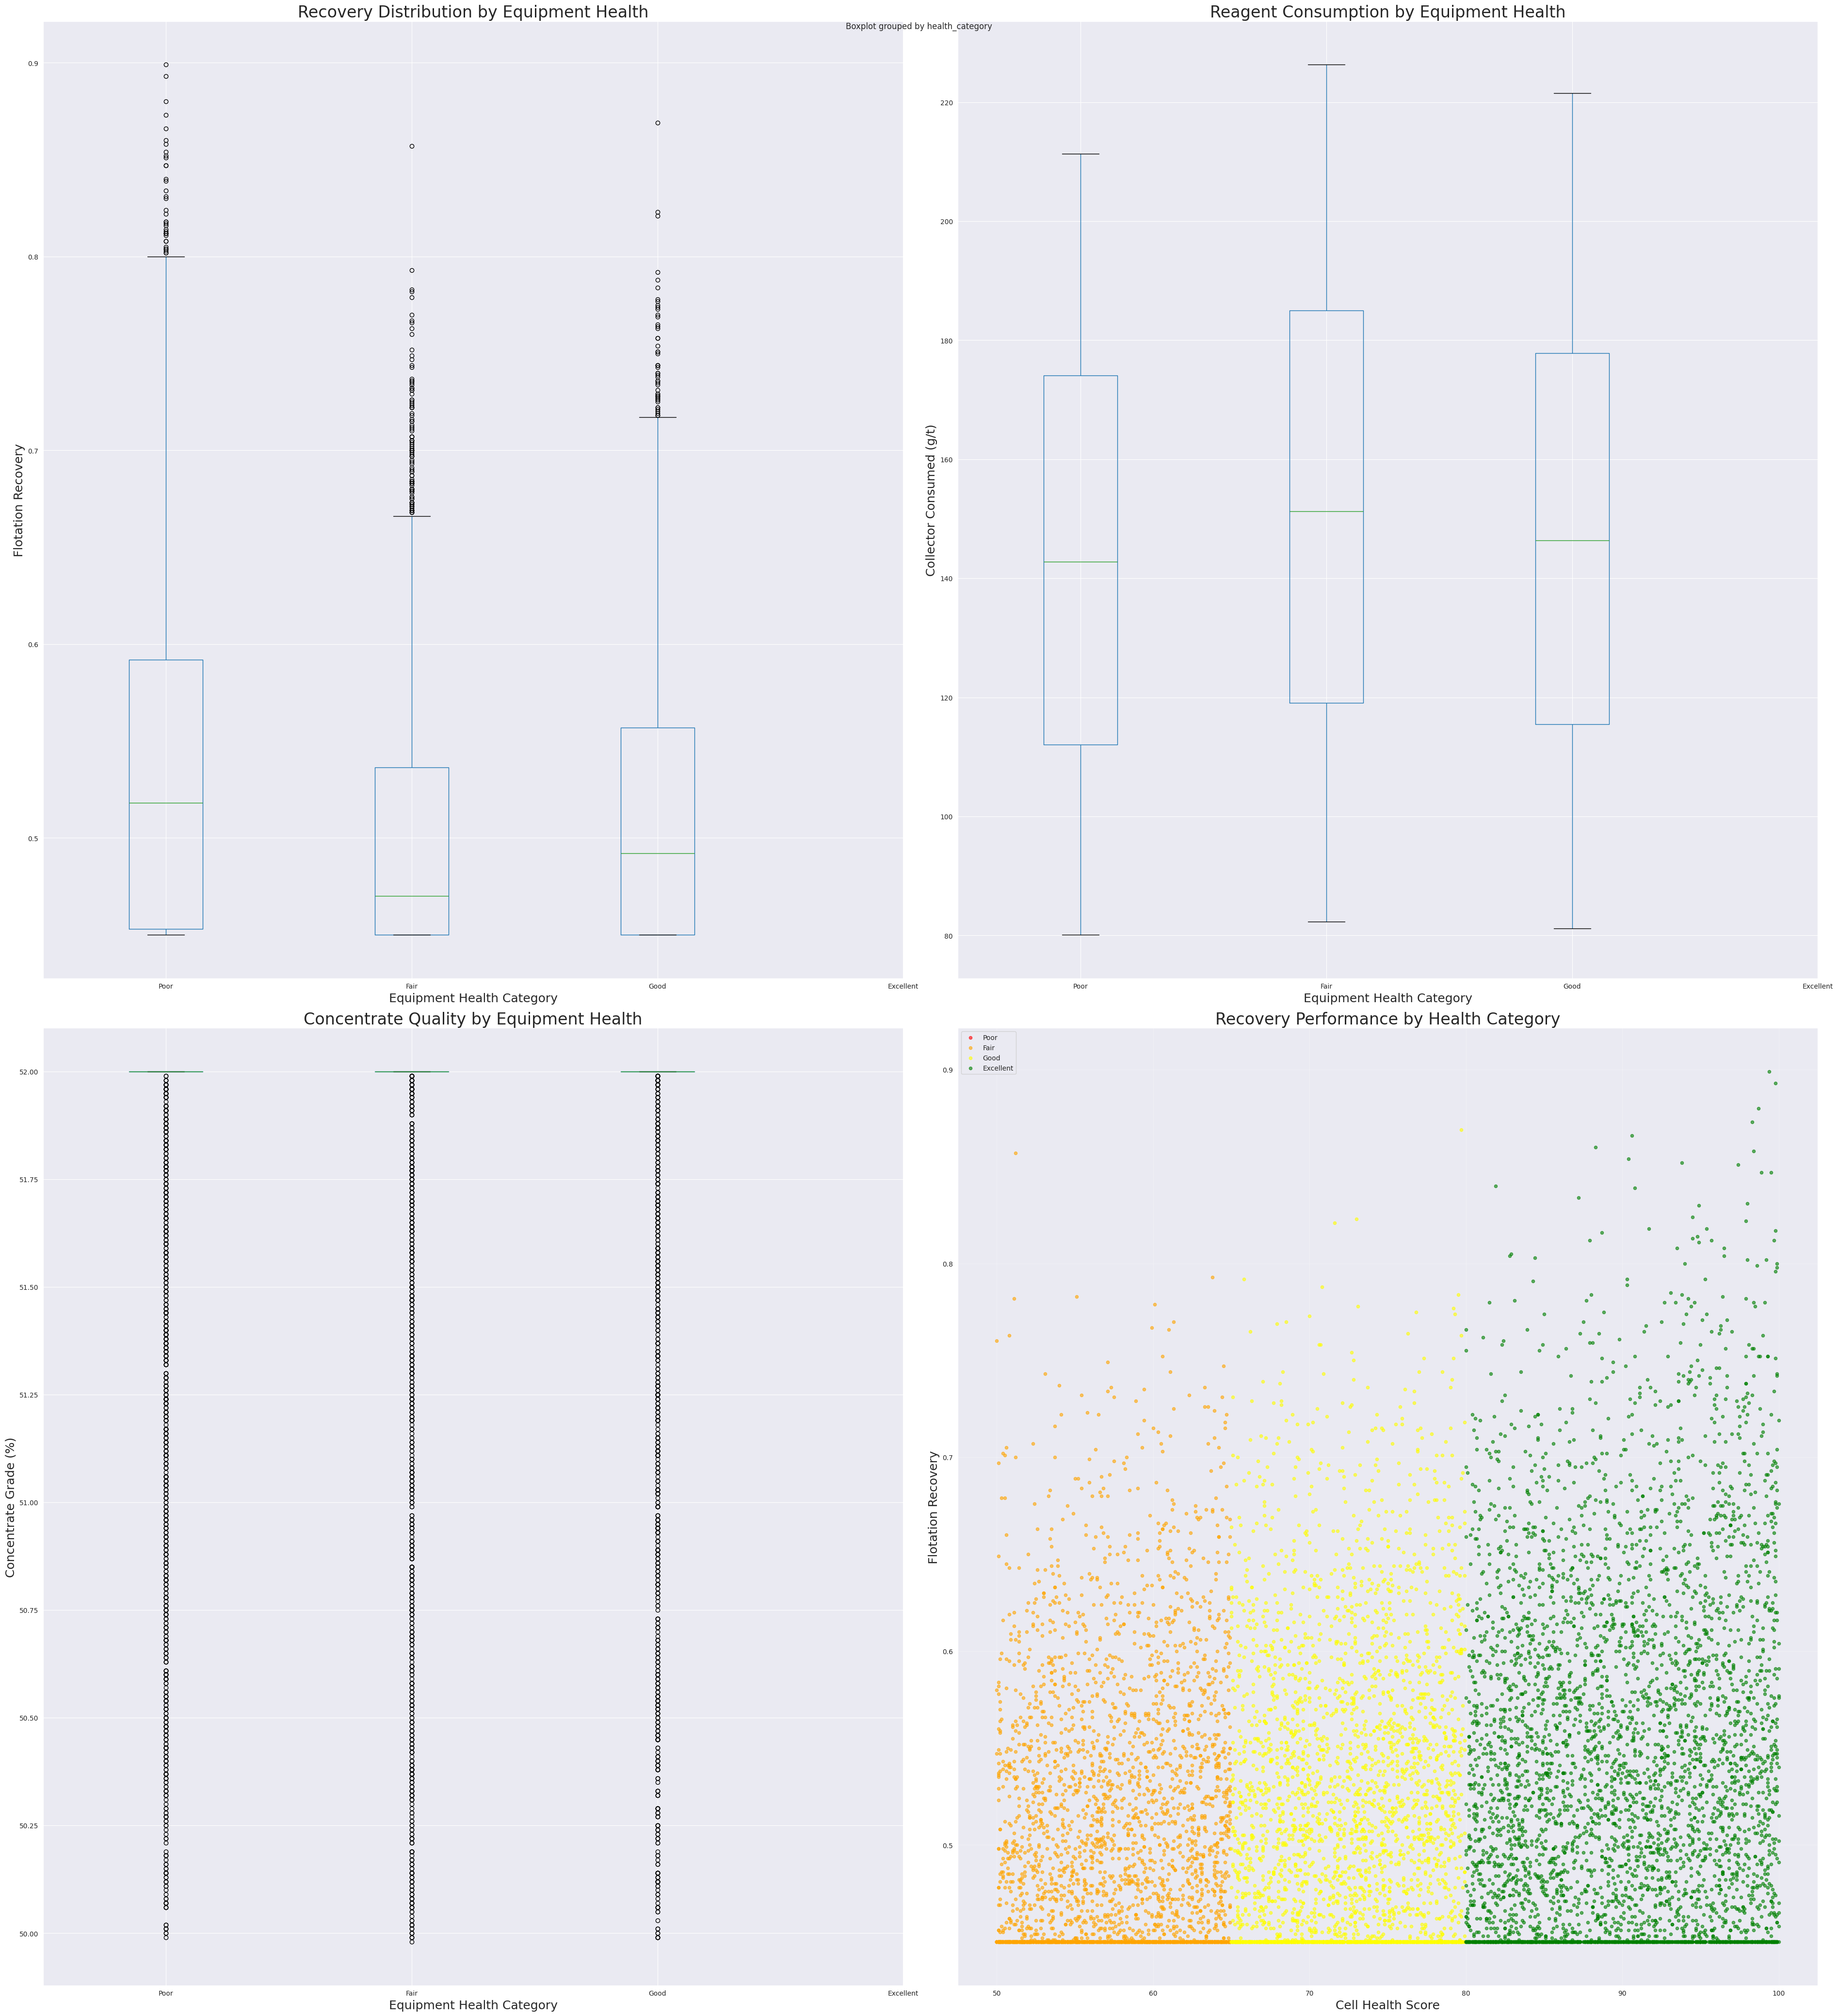


DMS PERFORMANCE BY CYCLONE HEALTH:
                 dms_recovery  separation_efficiency  media_consumption_kg_t
health_category                                                             
Excellent              0.7569                 0.6861                  1.2836
Fair                   0.7560                 0.6484                  1.4049
Good                   0.7572                 0.6666                  1.3589

ANOVA TEST: Equipment Health Impact on Recovery
F-statistic: 238.1049
P-value: 3.9078e-102
Result: Equipment health SIGNIFICANTLY affects recovery (p < 0.05)


In [31]:
# %%
# STEP 7C: EQUIPMENT DEGRADATION ANALYSIS
print("\n" + "=" * 60)
print("EQUIPMENT DEGRADATION & PERFORMANCE IMPACT")
print("=" * 60)

# Categorize equipment by health
def categorize_health(score):
    if score >= 80:
        return 'Excellent'
    elif score >= 65:
        return 'Good'
    elif score >= 50:
        return 'Fair'
    else:
        return 'Poor'

# Common font sizes
title_size = 24
label_size = 18
tick_size = 16

# Flotation recovery by health category
if 'flotation' in datasets:
    flot_df = datasets['flotation'].copy()
    if 'cell_health_score' in flot_df.columns:
        flot_df['health_category'] = flot_df['cell_health_score'].apply(categorize_health)

        fig, axes = plt.subplots(2, 2, figsize=(38, 42))

        # Box plot: Recovery by health category
        health_order = ['Poor', 'Fair', 'Good', 'Excellent']
        flot_df.boxplot(column='flotation_recovery', by='health_category', ax=axes[0,0])
        axes[0,0].set_xlabel('Equipment Health Category', fontsize=label_size)
        axes[0,0].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[0,0].set_title('Recovery Distribution by Equipment Health', fontsize=title_size)
        plt.sca(axes[0,0])
        plt.xticks(range(1, len(health_order)+1), health_order)

        # Statistics by category
        recovery_by_health = flot_df.groupby('health_category')['flotation_recovery'].agg(['mean', 'std', 'count'])
        print("\nFLOTATION RECOVERY BY HEALTH CATEGORY:")
        print(recovery_by_health.round(4))

        # Reagent consumption by health category
        if 'actual_collector_consumed_gt' in flot_df.columns:
            flot_df.boxplot(column='actual_collector_consumed_gt', by='health_category', ax=axes[0,1])
            axes[0,1].set_xlabel('Equipment Health Category', fontsize=label_size)
            axes[0,1].set_ylabel('Collector Consumed (g/t)', fontsize=label_size)
            axes[0,1].set_title('Reagent Consumption by Equipment Health', fontsize=title_size)
            plt.sca(axes[0,1])
            plt.xticks(range(1, len(health_order)+1), health_order)

        # Grade by health category
        flot_df.boxplot(column='concentrate_grade_pct', by='health_category', ax=axes[1,0])
        axes[1,0].set_xlabel('Equipment Health Category', fontsize=label_size)
        axes[1,0].set_ylabel('Concentrate Grade (%)', fontsize=label_size)
        axes[1,0].set_title('Concentrate Quality by Equipment Health', fontsize=title_size)
        plt.sca(axes[1,0])
        plt.xticks(range(1, len(health_order)+1), health_order)

        # Recovery vs Health scatter with categories
        colors = {'Poor': 'red', 'Fair': 'orange', 'Good': 'yellow', 'Excellent': 'green'}
        for category in health_order:
            mask = flot_df['health_category'] == category
            axes[1,1].scatter(flot_df[mask]['cell_health_score'],
                            flot_df[mask]['flotation_recovery'],
                            c=colors[category], label=category, alpha=0.6, s=20)
        axes[1,1].set_xlabel('Cell Health Score', fontsize=label_size)
        axes[1,1].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[1,1].set_title('Recovery Performance by Health Category', fontsize=title_size)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# DMS performance by cyclone health
if 'dms' in datasets:
    dms_df = datasets['dms'].copy()
    if 'cyclone_health_score' in dms_df.columns:
        dms_df['health_category'] = dms_df['cyclone_health_score'].apply(categorize_health)

        print("\nDMS PERFORMANCE BY CYCLONE HEALTH:")
        dms_by_health = dms_df.groupby('health_category')[['dms_recovery', 'separation_efficiency',
                                                           'media_consumption_kg_t']].mean()
        print(dms_by_health.round(4))

# Statistical significance test (ANOVA)
if 'flotation' in datasets and 'cell_health_score' in datasets['flotation'].columns:
    from scipy.stats import f_oneway

    flot_df = datasets['flotation'].copy()
    flot_df['health_category'] = flot_df['cell_health_score'].apply(categorize_health)

    groups = [group['flotation_recovery'].values for name, group in flot_df.groupby('health_category')]
    f_stat, p_value = f_oneway(*groups)

    print(f"\nANOVA TEST: Equipment Health Impact on Recovery")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("Result: Equipment health SIGNIFICANTLY affects recovery (p < 0.05)")
    else:
        print("Result: No significant effect detected")